# ML Pipeline

## Data Preparation

In [195]:
from utils import initialize_bucket, plot_importance

import pandas as pd
import numpy as np
import re
import ast

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import KFold, cross_val_score,cross_validate
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.preprocessing import StandardScaler, Normalizer

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import pickle
import json




### Extracting refined dataset from Google Storage Bucket

In [196]:
credentials_path = 'datascience-capstone-project-05b1642f45c3.json'

In [197]:
client, bucket = initialize_bucket(credentials_path,'storage-barsianize')

path = "gs://storage-barsianize/refined/base_dataset.csv"
base_dataset =  pd.read_csv(path, index_col=0)
df = base_dataset.copy()

In [198]:
a=0
b=50
df.columns[a:b]

Index(['Papel', 'Tipo', 'Empresa', 'Setor', 'Subsetor', 'dy_label',
       'cotacao_rel', 'cotacao_mean_median_ratio', 'cotacao_std',
       'cotacao_spread', 'cotacao_spread_rel_now', 'pl', 'pl_rel', 'pl_median',
       'pl_mean', 'pl_mean_median_ratio', 'pl_std', 'pl_spread',
       'pl_spread_rel_now', 'pvp', 'pvp_rel', 'pvp_median', 'pvp_mean',
       'pvp_mean_median_ratio', 'pvp_std', 'pvp_spread', 'pvp_spread_rel_now',
       'psr', 'psr_rel', 'psr_median', 'psr_mean', 'psr_std', 'psr_spread',
       'psr_spread_rel_now', 'dy', 'dy_rel', 'dy_median', 'dy_mean',
       'dy_mean_median_ratio', 'dy_std', 'dy_spread', 'dy_spread_rel_now',
       'pa', 'pa_rel', 'pa_median', 'pa_mean', 'pa_std', 'pa_spread',
       'pa_spread_rel_now', 'pcg'],
      dtype='object')

In [218]:
df[['Papel','Tipo','Setor','Subsetor']]

,Papel,Tipo,Setor,Subsetor
0,ABCB4,7,15,9
0,ABCB4,7,15,9
0,ABCB4,7,15,9
0,ABCB4,7,15,9
0,ABCB4,7,15,9
...,...,...,...,...
0,ENGI11,13,10,17
0,FRTA3,4,0,1
0,RAIL3,4,30,53
0,RNEW3,3,10,17


In [199]:
cor = df.corr()['dy_label']

<AxesSubplot:>

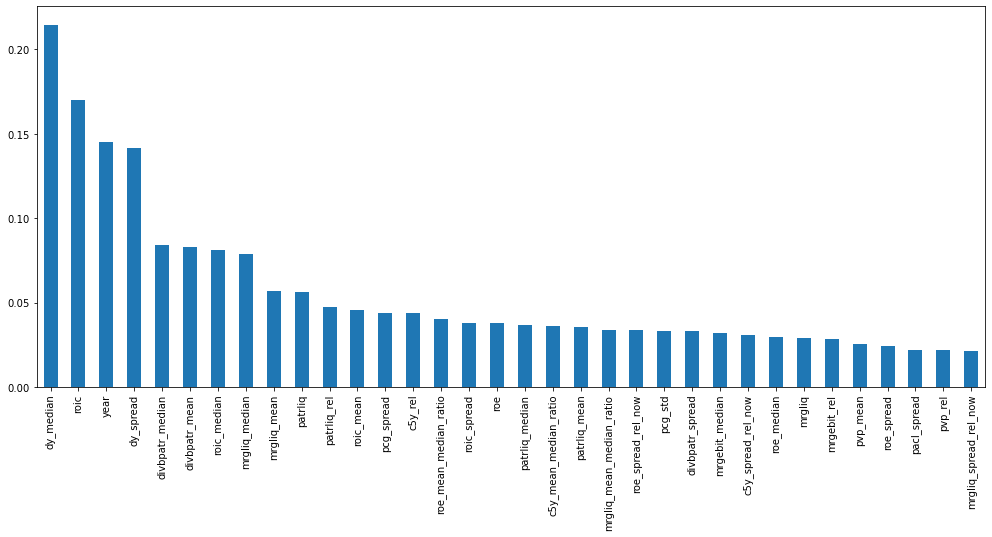

In [200]:
plt.figure(figsize=(17,7))
cor.sort_values(ascending=False)[1:35].plot(kind='bar')

<AxesSubplot:>

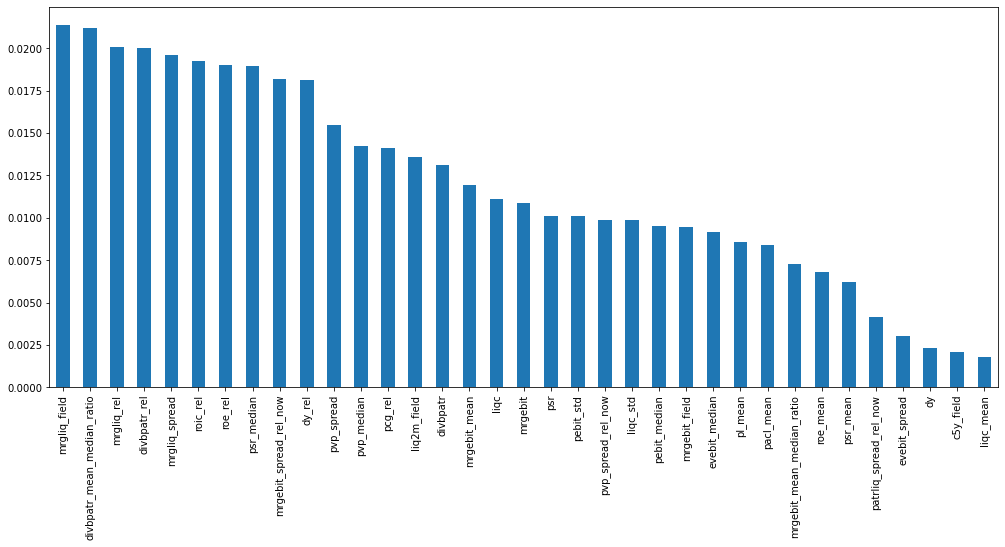

In [201]:
plt.figure(figsize=(17,7))
cor.sort_values(ascending=False)[35:70].plot(kind='bar')

<AxesSubplot:>

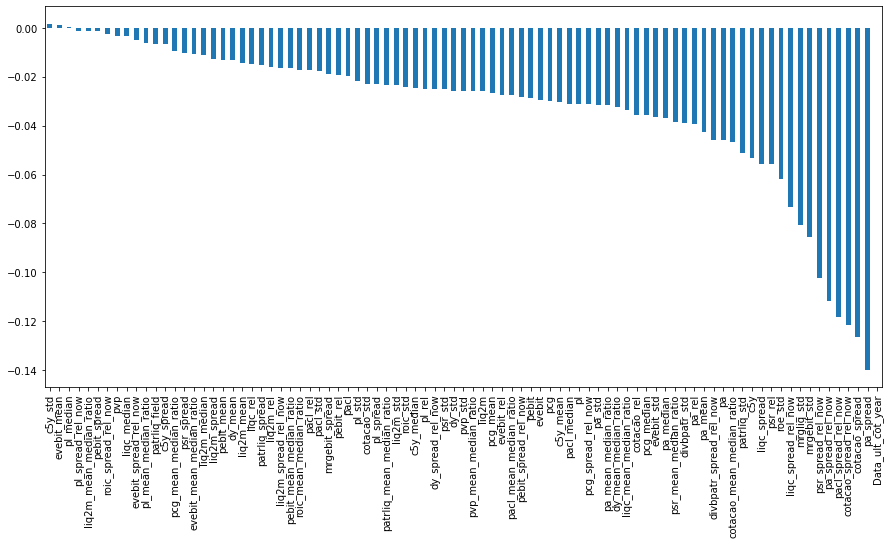

In [202]:
plt.figure(figsize=(15,7))
cor.sort_values(ascending=False)[70:].plot(kind='bar')

In [222]:
cor = df.corr()['dy_label']
training_features = cor[(cor>0.02)|(cor<-0.02)]

In [278]:
columns_to_log  = ['cotacao_rel','divbpatr_rel','mrgebit_rel','mrgliq_rel',
                   'dy_spread_rel_now', 'cotacao_spread_rel_now',
                   'pacl','divbpatr_median', 'pcg_median','c5y_rel',
                   'pcg_median', 'liqc_rel', 'pebit_spread_rel_now',
                   'mrgliq_mean','dy_mean', 'dy_median','pvp_rel', 'c5y_mean', 
                   'divbpatr_rel','dy_rel']
columns_to_drop = ['year']

In [282]:
def logging_vars(data, cols):
    data_out = data.copy()
    for col in cols:
        data_out[col + '_log'] = np.log(data_out[col]+1)
    return data_out

In [283]:
df_log = logging_vars(df, columns_to_log)

c:\Users\Pontello\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Pontello\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Pontello\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Pontello\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Pontello\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Pontello\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value enc

In [293]:
df_log.head()
df_log.replace([np.inf, -np.inf], np.nan, inplace=True)
df_log = df_log.dropna()

In [294]:
cor_log = df_log.corr()['dy_label']

<AxesSubplot:>

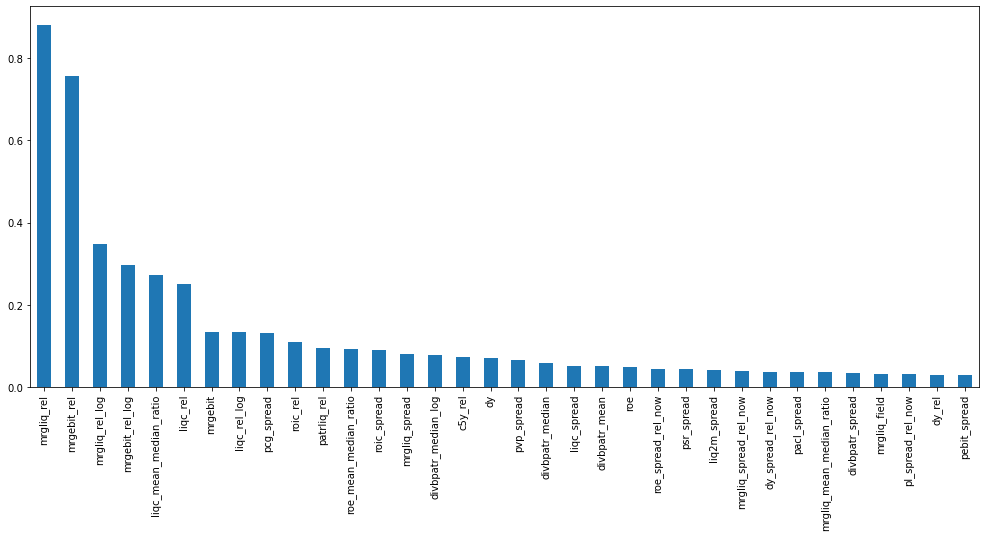

In [295]:
plt.figure(figsize=(17,7))
cor_log.sort_values(ascending=False)[1:35].plot(kind='bar')

<AxesSubplot:>

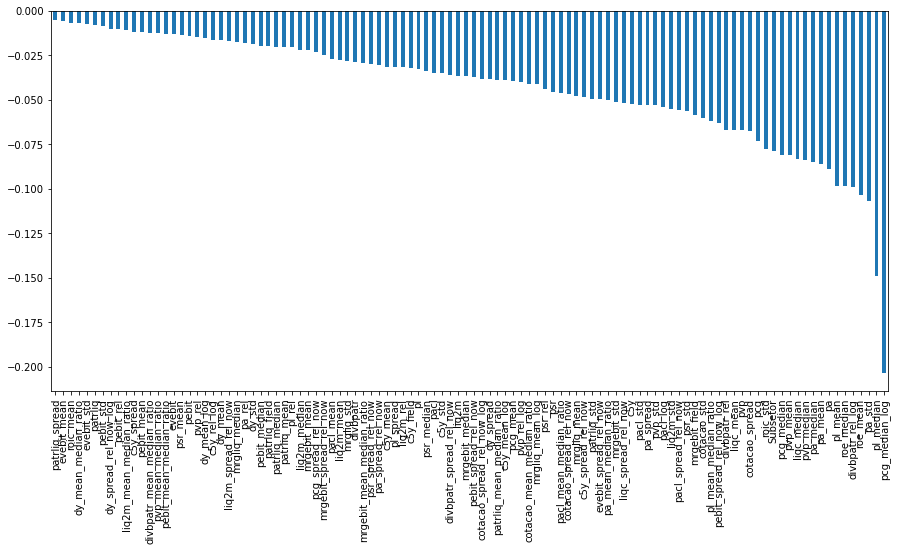

In [296]:
plt.figure(figsize=(15,7))
cor_log.sort_values(ascending=False)[70:].plot(kind='bar')

In [204]:
df.describe()

,dy_label,cotacao_rel,cotacao_mean_median_ratio,cotacao_std,cotacao_spread,cotacao_spread_rel_now,pl,pl_rel,pl_median,pl_mean,...,pa_mean_median_ratio,pcg_mean_median_ratio,pebit_mean_median_ratio,pacl_mean_median_ratio,evebit_mean_median_ratio,mrgebit_mean_median_ratio,mrgliq_mean_median_ratio,roic_mean_median_ratio,liqc_mean_median_ratio,divbpatr_mean_median_ratio
count,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,...,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000
mean,0.044036,6.560779,1.241269,10.144679,1.244744,0.164750,12.680972,1.002948,11.033338,11.358299,...,1.245360,4.045369,2.056547,2.601036,2.026576,1.435454,-16.908387,1.322797,1.087219,-1.134469
std,0.071733,27.542368,1.327243,18.682943,0.748153,0.369662,48.009322,12.152747,11.925733,33.993932,...,3.540615,44.797004,9.263185,18.549616,8.222038,11.135908,270.824893,5.746759,0.332408,61.810624
min,0.000000,0.000000,0.747083,0.000000,0.000000,0.001086,-486.400000,-187.142857,-88.045000,-274.295000,...,0.752087,-127.944444,-40.476496,-41.581871,-34.321664,-117.473195,-6143.746000,-7.163636,0.716374,-1726.333333
25%,0.002750,0.844086,0.990180,2.779653,0.713059,0.028098,4.590000,0.284501,4.678750,1.323750,...,0.992445,0.998693,0.977385,0.984791,0.983935,0.941944,0.793875,0.944244,0.991068,0.976667
50%,0.029600,1.451459,1.048658,5.554309,1.085712,0.059001,9.945000,0.937413,9.485000,10.204167,...,1.038553,1.089261,1.054320,1.105833,1.049922,0.995152,0.992568,1.017710,1.029630,1.005401
75%,0.060450,2.844312,1.154890,10.702320,1.573143,0.164798,18.770000,1.649586,15.402500,19.448750,...,1.118761,1.403072,1.196578,1.263190,1.179056,1.104274,1.599598,1.184380,1.112299,1.071911
max,1.473600,523.076923,27.227053,263.233432,6.000000,5.568689,461.890000,225.200000,83.020000,284.240000,...,99.680763,1177.928571,141.109948,318.502802,115.629288,72.367954,317.677396,156.709720,4.666667,35.224242


In [205]:
df.head()

,Papel,Tipo,Empresa,Setor,Subsetor,dy_label,cotacao_rel,cotacao_mean_median_ratio,cotacao_std,cotacao_spread,...,pa_mean_median_ratio,pcg_mean_median_ratio,pebit_mean_median_ratio,pacl_mean_median_ratio,evebit_mean_median_ratio,mrgebit_mean_median_ratio,mrgliq_mean_median_ratio,roic_mean_median_ratio,liqc_mean_median_ratio,divbpatr_mean_median_ratio
0,ABCB4,PN N2,ABC Brasil PN N2,Intermediários Financeiros,Bancos,0.0308,1.169838,1.021558,3.690056,0.761940,...,1.038553,1.089261,1.05432,1.105833,1.049922,0.941944,0.89565,1.228916,1.112299,1.0
0,ABCB4,PN N2,ABC Brasil PN N2,Intermediários Financeiros,Bancos,0.0466,1.377959,0.967302,3.944564,0.737458,...,1.038553,1.089261,1.05432,1.105833,1.049922,0.941944,0.89565,1.228916,1.112299,1.0
0,ABCB4,PN N2,ABC Brasil PN N2,Intermediários Financeiros,Bancos,0.0322,1.923932,0.935683,5.110157,0.926367,...,1.038553,1.089261,1.05432,1.105833,1.049922,0.941944,0.89565,1.228916,1.112299,1.0
0,ABCB4,PN N2,ABC Brasil PN N2,Intermediários Financeiros,Bancos,0.0581,1.920000,0.972123,4.748051,0.891643,...,1.038553,1.089261,1.05432,1.105833,1.049922,0.941944,0.89565,1.228916,1.112299,1.0
0,ABCB4,PN N2,ABC Brasil PN N2,Intermediários Financeiros,Bancos,0.0849,0.861673,1.049383,2.626752,0.407021,...,1.038553,1.089261,1.05432,1.105833,1.049922,0.941944,0.89565,1.228916,1.112299,1.0


#### Defining Label

In [206]:
df.isna().sum().sort_values(ascending=False)

Papel                         0
roe_spread                    0
liqc                          0
liqc_rel                      0
liqc_median                   0
                             ..
pebit                         0
pebit_rel                     0
pebit_median                  0
pebit_mean                    0
divbpatr_mean_median_ratio    0
Length: 165, dtype: int64

#### Adjust data types

In [207]:
df.columns

Index(['Papel', 'Tipo', 'Empresa', 'Setor', 'Subsetor', 'dy_label',
       'cotacao_rel', 'cotacao_mean_median_ratio', 'cotacao_std',
       'cotacao_spread',
       ...
       'pa_mean_median_ratio', 'pcg_mean_median_ratio',
       'pebit_mean_median_ratio', 'pacl_mean_median_ratio',
       'evebit_mean_median_ratio', 'mrgebit_mean_median_ratio',
       'mrgliq_mean_median_ratio', 'roic_mean_median_ratio',
       'liqc_mean_median_ratio', 'divbpatr_mean_median_ratio'],
      dtype='object', length=165)

#### Numerical encoding for object variables

In [208]:
features_to_drop = ['Data_ult_cot','papel','date','Data_ult_cot_year','year']
df.drop(features_to_drop, axis=1, inplace=True)

In [209]:
df_objects = df.select_dtypes('object').copy()
df_objects = df_objects.drop(['Empresa','Papel'], axis=1)
object_cols = df_objects.columns
print(object_cols)

Index(['Tipo', 'Setor', 'Subsetor'], dtype='object')


In [210]:
for col in object_cols:
    df[col] = df_objects[col].astype('category').cat.codes

df.dtypes

Papel                          object
Tipo                             int8
Empresa                        object
Setor                            int8
Subsetor                         int8
                               ...   
mrgebit_mean_median_ratio     float64
mrgliq_mean_median_ratio      float64
roic_mean_median_ratio        float64
liqc_mean_median_ratio        float64
divbpatr_mean_median_ratio    float64
Length: 160, dtype: object

#### Spliting data into training a test data

In [211]:
X.max().sort_values(ascending=False)

liq2m_spread_rel_now        1.872418e+11
liq2m_mean_median_ratio     1.202413e+11
evebit_std                  4.750459e+07
pebit_std                   2.399578e+07
evebit_mean_median_ratio    1.812493e+07
                                ...     
roe_median                  1.952950e+00
roic                        1.257500e+00
roic_mean                   6.538167e-01
roic_median                 6.519000e-01
dy_median                   1.560000e-01
Length: 151, dtype: float64

In [223]:
cor

dy_label                      1.000000
cotacao_rel                  -0.035531
cotacao_mean_median_ratio    -0.046871
cotacao_std                  -0.022961
cotacao_spread               -0.126449
                                ...   
mrgebit_mean_median_ratio     0.007243
mrgliq_mean_median_ratio      0.033832
roic_mean_median_ratio       -0.017199
liqc_mean_median_ratio       -0.033621
divbpatr_mean_median_ratio    0.021184
Name: dy_label, Length: 157, dtype: float64

In [297]:
cor = df_log.corr()['dy_label']
minimum = 0.012
maximum = 0.7
training_features = cor_log[((cor_log>minimum)&(cor_log<maximum))|((cor_log>-maximum)&(cor_log<-minimum))]

features X_train: 138
features X_test: 138
R2 score: 0.21332656690633148
Mean squared error: 0.011010114592227541
test score: -0.056332685007333794 
train score: 0.9862316087529152


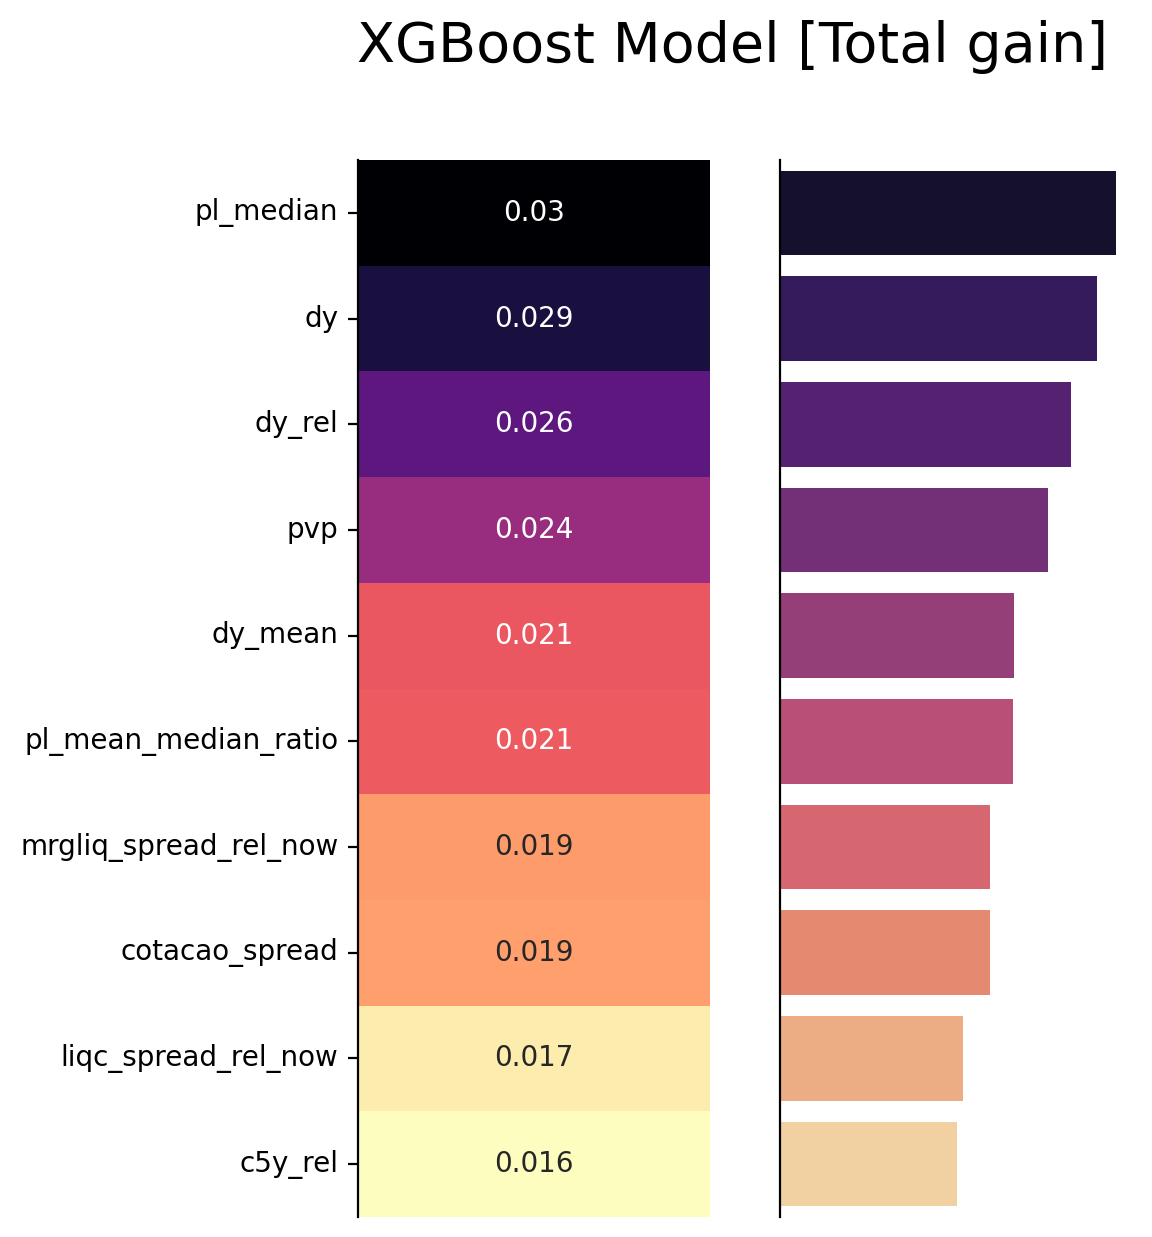

In [298]:
# using the standard scaler to standardize the data
# scaler = StandardScaler()
scaler = Normalizer()

# separating the train and target features
# X = df.drop(['Papel','Empresa','dy_label'], axis=1)
X = df_log[training_features.index]
y = df_log['dy_label']

# train and test datasets split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# standardization of the dataset
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# check the shape of the train and test datasets
print(f'features X_train: {len(X_train[1])}\nfeatures X_test: {len(X_test[1])}')

# define the XGBoost model with your preferred hyperparameters
xgb_model = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1)

# define the cross-validation method (e.g. KFold with 5 folds)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# define the evaluation metrics (r2 score and mean squared error)
scoring = {'r2': make_scorer(r2_score), 'mse': make_scorer(mean_squared_error)}

# perform cross-validation and get the scores
scores = cross_validate(xgb_model, X, y, cv=cv, scoring=scoring)
xgb_model.fit(X_train, y_train)
xgb_model_pred_train=xgb_model.predict(X_train)
xgb_model_pred_test=xgb_model.predict(X_test)

print('R2 score:', np.mean(scores['test_r2']))
print('Mean squared error:', np.mean(scores['test_mse']))

# # define your cross validation strategy
# cv = KFold(n_splits=5, shuffle=True, random_state=42)

# # evaluate the XGBoost model with cross validation
# xgscore = cross_val_score(xgb_model, X, y, cv=cv, scoring=['neg_mean_squared_error','r2_score'])

# # print the mean and standard deviation of the cross validation scores
# print('Cross Validation Scores:')
# print('Mean:', np.mean(xgscore))
# print('Std:', np.std(xgscore))

# printing cross validation results
# print(f'XGBoost cross val score: {scoring}')

# # analysing train and test data results
train_score_xgb_model =  r2_score(y_train, xgb_model_pred_train)
test_score_xgb_model = r2_score(y_test, xgb_model_pred_test)
# printing r2 scores of training and test
print(f'test score: {test_score_xgb_model} \ntrain score: {train_score_xgb_model}')

# getting the most important features
dict_importance = xgb_model.get_booster().get_score(importance_type="total_gain")
d={}
# cleanse the data
for index, value in dict_importance.items():
    d[X.columns[int(index[1:])]] = value
# transforming data to a dataframe
most_important_XGBoost_review = pd.DataFrame(d, index=['Total gain']).T
most_important_XGBoost_review = most_important_XGBoost_review[['Total gain']].sort_values(ascending=False, by='Total gain')

# plot most important features
plot_importance(most_important_XGBoost_review, 'Total gain', 'XGBoost Model [Total gain]')

In [269]:
most_important_XGBoost_review.iloc[25:50].index

Index(['mrgebit_spread', 'pl_spread', 'mrgliq_mean_median_ratio',
       'pcg_spread_rel_now', 'cotacao_rel', 'pl_std', 'c5y_rel', 'mrgliq_std',
       'Subsetor', 'pcg_median', 'liqc_rel', 'pebit_spread_rel_now',
       'mrgliq_mean', 'Tipo', 'pvp_spread', 'dy_mean', 'dy_median', 'Setor',
       'pvp_rel', 'c5y_mean', 'divbpatr_rel', 'divbpatr_mean_median_ratio',
       'pebit_mean_median_ratio', 'dy_rel'],
      dtype='object')

features X_train: 50
features X_test: 50
R2 score: 0.2548082441405978
Mean squared error: 0.010876012376277519
test score: -0.05543673338691257 
train score: 0.9917067726811493


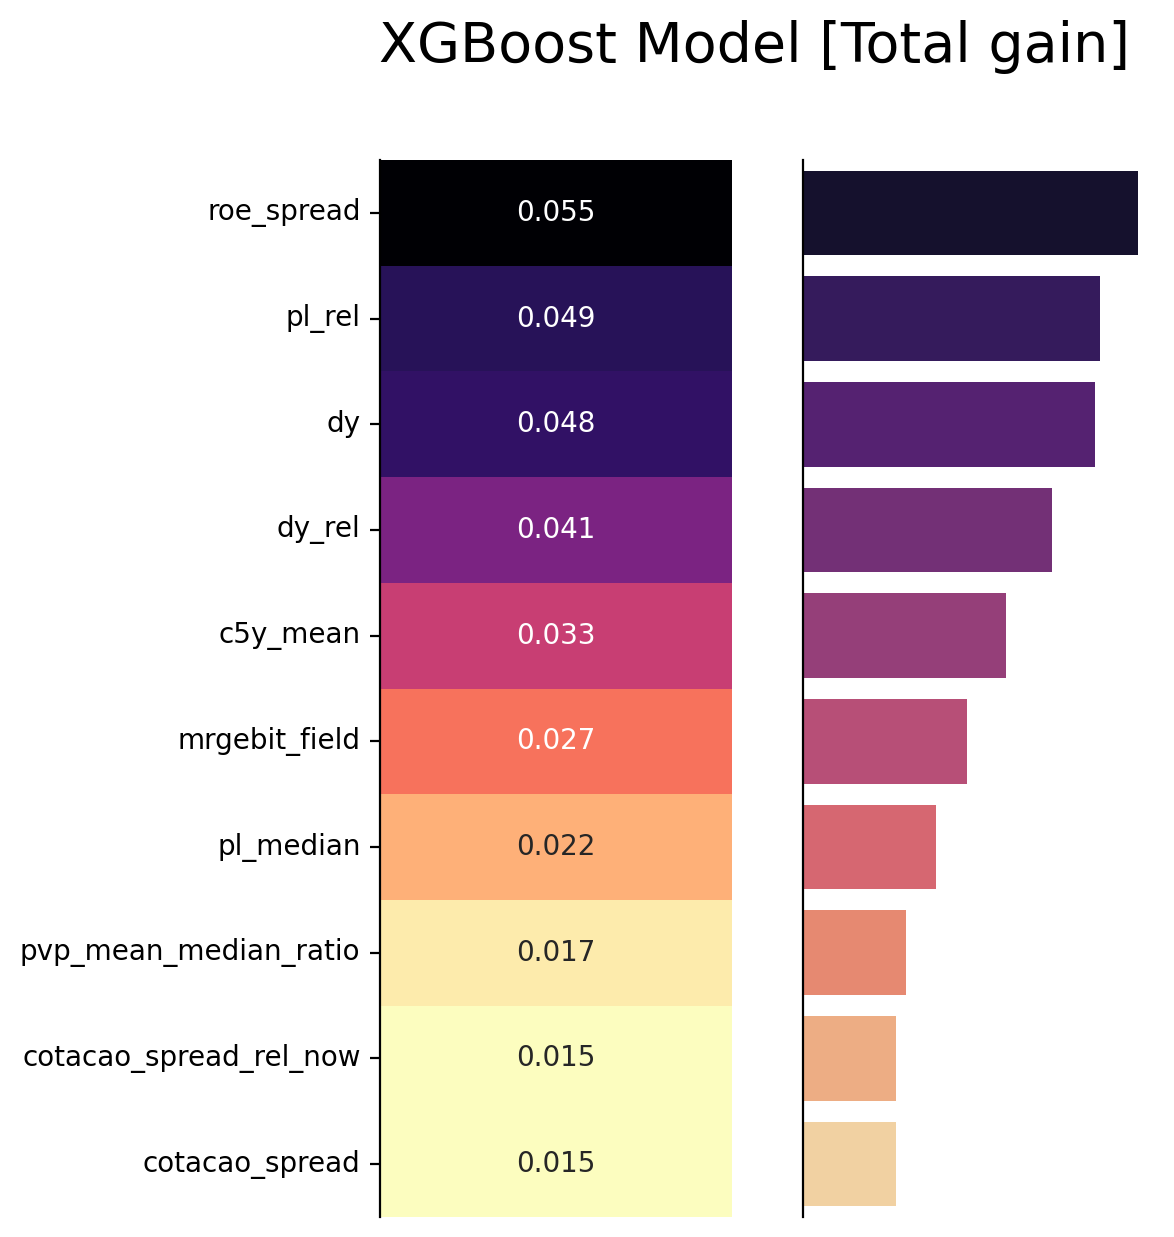

In [300]:
# using the standard scaler to standardize the data
# scaler = StandardScaler()
scaler = Normalizer()

# separating the train and target features
X = df_log[most_important_XGBoost_review.iloc[:50].index]
y = df_log['dy_label']

# train and test datasets split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# standardization of the dataset
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# check the shape of the train and test datasets
print(f'features X_train: {len(X_train[1])}\nfeatures X_test: {len(X_test[1])}')

# define the XGBoost model with your preferred hyperparameters
xgb_model = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1)

# define the cross-validation method (e.g. KFold with 5 folds)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# define the evaluation metrics (r2 score and mean squared error)
scoring = {'r2': make_scorer(r2_score), 'mse': make_scorer(mean_squared_error)}

# perform cross-validation and get the scores
scores = cross_validate(xgb_model, X, y, cv=cv, scoring=scoring)
xgb_model.fit(X_train, y_train)
xgb_model_pred_train=xgb_model.predict(X_train)
xgb_model_pred_test=xgb_model.predict(X_test)

print('R2 score:', np.mean(scores['test_r2']))
print('Mean squared error:', np.mean(scores['test_mse']))

# # define your cross validation strategy
# cv = KFold(n_splits=5, shuffle=True, random_state=42)

# # evaluate the XGBoost model with cross validation
# xgscore = cross_val_score(xgb_model, X, y, cv=cv, scoring=['neg_mean_squared_error','r2_score'])

# # print the mean and standard deviation of the cross validation scores
# print('Cross Validation Scores:')
# print('Mean:', np.mean(xgscore))
# print('Std:', np.std(xgscore))

# printing cross validation results
# print(f'XGBoost cross val score: {scoring}')

# # analysing train and test data results
train_score_xgb_model =  r2_score(y_train, xgb_model_pred_train)
test_score_xgb_model = r2_score(y_test, xgb_model_pred_test)
# printing r2 scores of training and test
print(f'test score: {test_score_xgb_model} \ntrain score: {train_score_xgb_model}')

# getting the most important features
dict_importance = xgb_model.get_booster().get_score(importance_type="total_gain")
d={}
# cleanse the data
for index, value in dict_importance.items():
    d[X.columns[int(index[1:])]] = value
# transforming data to a dataframe
most_important_XGBoost_review = pd.DataFrame(d, index=['Total gain']).T
most_important_XGBoost_review = most_important_XGBoost_review[['Total gain']].sort_values(ascending=False, by='Total gain')

# plot most important features
plot_importance(most_important_XGBoost_review, 'Total gain', 'XGBoost Model [Total gain]')

### Building a Machine Learning Pipeline 

In [215]:
def build_pipelines(regressors):
    pipelines = {}
    for algorithm,regressor in regressors.items():
        pipeline = Pipeline([
            ('reg',regressor)
        ])
        pipelines[algorithm] = pipeline

    return pipelines

In [216]:

def build_models(classifiers,parameters_dict):
    pipelines = build_pipelines(classifiers)

    cvs = {}
    
    for algorithm,parameters in parameters_dict.items():
        # create grid search object
        cv = GridSearchCV(pipelines[algorithm], param_grid=parameters)
        cvs[algorithm] = cv
    
    return cvs

In [217]:
def display_and_store_results(cv,y_test,y_pred,algorithm):
    
    columns = y_test.columns
    classification_reports = []
    for i, col in enumerate(columns):
        print(col)
        classif_report = classification_report(y_test[col], y_pred[:,i])
        print(classif_report)
        classification_reports.append(classif_report)
        print('___________________________________')
        
    print("\nBest Parameters:", cv.best_params_)
    print('##################################')

    performance = {
        'algorithm':algorithm,
        'best_params':cv.best_params_,
        'class':classification_reports
    }

    patch = '../data/03_models/out/'
    filename = patch + algorithm

    json.dump(performance, open(filename+'_results.json', 'w'))   
    pickle.dump(cv.best_estimator_, open(filename+'.pkl', 'wb'))



    

def main():
    X, y = load_data()
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3)

    # reading the training parameters for grid search
    with open('../data/03_models/in/params.json') as json_file:
        parameters = json.load(json_file)
        for key_1, value_1 in params.items():
            for key_2, value_2 in value_1.items():
                parameters[key_1][key_2] = ast.literal_eval(value_2)

    # defining which classifiers are going to be used
    regressors = {
        'LGBMRegressor':LGBMRegressor(),
        'XGBRegressor':XGBRegressor(),
        'RandomForestRegressor':RandomForestRegressor()
    }

    models = build_models(regressors,parameters)

    for algorithm, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        display_and_store_results(model, y_test, y_pred, algorithm)

    return models


models  = main()

NameError: name 'load_data' is not defined

In [ ]:
regressors = {
        'LGBMRegressor':LGBMRegressor(),
        'XGBRegressor':XGBRegressor(),
        'RandomForestRegressor':RandomForestRegressor()
    }

with open('data/params.json') as json_file:
        parameters = json.load(json_file)
        for key_1, value_1 in parameters.items():
            for key_2, value_2 in value_1.items():
                parameters[key_1][key_2] = ast.literal_eval(value_2)

models = build_models(regressors,parameters)